In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install jinja2
%pip install imblearn
%pip install xgboost
%pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,precision_score, log_loss, f1_score, accuracy_score, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
import pickle
from IPython.display import display, Markdown
import shap
import lightgbm
from xgboost import plot_importance

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
np.random.seed(31415)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Import Datasets and clean them - drop unused columns and fill empty values - drop rows with empty columns after cleaning 

In [2]:
## Import detailed Dataset
detailed_shots = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/detailed_shots_dataset_new.csv')
detailed_shots_clean = detailed_shots.drop(detailed_shots.columns[[0,5,6,7,8,3,11,12,13,14,17,18,20,21,22,23,25,33,34]] ,axis=1)
## fill time_between_shots_s with 0 when the data is missing => happens to be at the forst shot of the game per team
print(len(detailed_shots_clean[detailed_shots_clean['time_between_shots_s'].isna()]))
detailed_shots_clean['time_between_shots_s'] = np.where(detailed_shots_clean['time_between_shots_s'].isna(), 0, detailed_shots_clean['time_between_shots_s'])
## fill speed of the ball with mean for missing values
detailed_shots_clean['speed_ball'] = np.where(detailed_shots_clean['speed_ball'].isna(), detailed_shots_clean['speed_ball'].mean(), detailed_shots_clean['speed_ball']) ## just fill this value so the records dont get deletet in the dataset
## Fill player speed with mean for missing values
print(len(detailed_shots_clean[detailed_shots_clean['player_speed'].isna()]))
detailed_shots_clean['player_speed'] = np.where(detailed_shots_clean['player_speed'].isna(), detailed_shots_clean['player_speed'].mean(), detailed_shots_clean['player_speed'])
detailed_shots_clean['powerplay'] = pd.Series(detailed_shots_clean['powerplay']).astype("boolean")
detailed_shots_clean['empty_net'] = pd.Series(detailed_shots_clean['empty_net']).astype("boolean")
## Delete Rows with missing data => 7 shots where no shooter could be assigned to gets removed
if not detailed_shots_clean[detailed_shots_clean.isna().any(axis=1)].empty:
    print(len(detailed_shots_clean[detailed_shots_clean.isna().any(axis=1)]))
    detailed_shots_clean = detailed_shots_clean.dropna()

categorical_shot_attributes_detailed = []
numerical_shot_attributes_detailed = ["distance",
                                      "visible_angle", "angle_to_mid", "time_between_shots_s", "dist_closest_def","shooter_goalkeeper_dist", "shot_goalkeeper_dist",
                                      "shooter_goalkeeper_angle", "shot_goalkeeper_angle",
                                      "player_speed", "number_of_passes", "ball_posession","pressur_index", "players_in_shot_angle_from_shot",
                                      "players_in_shot_angle_from_player", "powerplay", "empty_net"]

## Import simple Dataset
simple_shots = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/simple_shots_dataset.csv')
simple_shots_clean = simple_shots.drop(simple_shots.columns[[0,5,6,7,8,11,12,13,14,17,18,20,21,22,23,25,33,34]] ,axis=1)
## fill time_between_shots_s with 0 when the data is missing => happens to be at the forst shot of the game per team
simple_shots_clean['time_between_shots_s'] = np.where(simple_shots_clean['time_between_shots_s'].isna(), 0, simple_shots_clean['time_between_shots_s'])
## fill speed of the ball with mean for missing values
simple_shots_clean['speed_ball'] = np.where(simple_shots_clean['speed_ball'].isna(), simple_shots_clean['speed_ball'].mean(), simple_shots_clean['speed_ball']) ## just fill this value so the records dont get deletet in the dataset
## Delete Rows with missing data => no rows withmissing data left
if not simple_shots_clean[simple_shots_clean.isna().any(axis=1)].empty:
    print(len(simple_shots_clean[simple_shots_clean.isna().any(axis=1)]))
    simple_shots_clean = simple_shots_clean.dropna()

categorical_shot_attributes_simple = []
numerical_shot_attributes_simple = ["distance","visible_angle", "angle_to_mid"]

simple_dict = {"dataset": simple_shots_clean, "cat_attr": categorical_shot_attributes_simple, "num_attr": numerical_shot_attributes_simple, "name": "simple"}
detailed_dict = {"dataset": detailed_shots_clean, "cat_attr": categorical_shot_attributes_detailed, "num_attr": numerical_shot_attributes_detailed, "name": "detailed"}
datasets = [simple_dict, detailed_dict]

10
10
7
1


In [3]:
display(detailed_shots_clean.columns)
display(detailed_shots.columns)

Index(['Unnamed: 0', 'player_id', 'success', 'distance', 'speed_ball', 'id',
       'league_id', 'team', 'match_id', 'merge_time_shots', 'halftime', 'home',
       'norm_x_shot', 'norm_y_shot', 'visible_angle', 'angle_to_mid',
       'time_between_shots_s', 'pressur_index', 'dist_closest_def',
       'players_in_shot_angle_from_shot', 'players_in_shot_angle_from_player',
       'powerplay', 'shooter_goalkeeper_dist', 'shot_goalkeeper_dist',
       'shooter_goalkeeper_angle', 'shot_goalkeeper_angle', 'empty_net',
       'player_speed', 'number_of_passes', 'ball_posession'],
      dtype='object')

Index(['Unnamed: 0.1', 'Unnamed: 0', 'player_id', 'timestamp', 'success',
       'hit_position_z', 'hit_position_y', 'shot_position_y',
       'shot_position_x', 'distance', 'speed_ball', 'shot_type', 'game_clock',
       'validated', 'goalkeeper_id', 'id', 'league_id', 'goalkeeper_league_id',
       'action_id', 'team', 'last_group', 'event', 'updated_at', 'team_id',
       'match_id', 'timestamp_dt', 'merge_time_shots', 'halftime', 'home',
       'norm_x_shot', 'norm_y_shot', 'visible_angle', 'angle_to_mid',
       'score_home', 'score_away', 'time_between_shots_s', 'pressur_index',
       'dist_closest_def', 'players_in_shot_angle_from_shot',
       'players_in_shot_angle_from_player', 'powerplay',
       'shooter_goalkeeper_dist', 'shot_goalkeeper_dist',
       'shooter_goalkeeper_angle', 'shot_goalkeeper_angle', 'empty_net',
       'player_speed', 'number_of_passes', 'ball_posession'],
      dtype='object')

# Define Util Functions
First define a pipeline to preprocess the data 

In [4]:
## Create DataFrame to store Results per Test and Evaluation per Dataset per Method
result_df = pd.DataFrame(columns=["Dataset", "Classifier", "Comb", "log_loss_training", "auc_train", ])
eval_result_df = pd.DataFrame(columns=["Dataset", "Classifier", "Comb", "log_loss_test", 'recall', 'f1','auc'])

In [5]:
def make_training_report(scores, scores_auc):
    print("###Validation Results###")
    print("training set results: {0}".format(scores.max()))
    print("training set auc results: {0}".format(scores_auc.max()))
    print("")
    
def add_new_training_result(ds_name, classifier_name, comb, scores, scores_auc):
    return pd.DataFrame({'Dataset': dataset_dict['name'], 'Classifier': classifier_name, 'Comb': comb, 'log_loss_training': scores.max(), 
                        'auc_train': scores_auc.max()
                        }, index=[len(result_df)+1])

def add_new_eval_result(ds_name, classifier_name, y_test, y_test_pred,y_test_pred_proba, comb):
    return pd.DataFrame({'Dataset': ds_name, 'Classifier': classifier_name, 'Comb': comb, 'log_loss_test': log_loss(y_test, y_test_pred_proba, normalize=True),
                      'recall': recall_score(y_test, y_test_pred) , 'f1': f1_score(y_test, y_test_pred), 'auc': roc_auc_score(y_test, y_test_pred_proba[:, 1])
                }, index=[len(eval_result_df)+1])
    
def full_pipeline(comb, X_train, y_train, X_test, y_test, numeric_features,categorical_features, clf, hyperparameter_dist, result_df, eval_result_df, scoring="f1", n_iter=20, rfe=False, os=False, 
                  n_features_to_select=None, log=False, save=False, calibration=False, cv=10):
    ## Select all Features and standarize them => categorial gets passed through
    preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), numeric_features),
                     (('cat', OneHotEncoder(), categorical_features))])
    steps=[('preprocessor', preprocessor)]

    ## Do a Feature Selection after standardization
    if rfe:
        selector = RFE(clf, n_features_to_select=n_features_to_select, step=1)
        steps.append(('selector',selector))
    ## Do Oversampling after RFE and standardization
    if os:
        smt = SMOTE(random_state=0)
        steps.append(('oversampling', smt))
    steps.append(('classifier', clf))
    ## Create Pipeline with preprocessing steps
    combined_pipeline = Pipeline(steps=steps)
    
    ## Hyperparameter Optimization and Validate the Training
    print("Optimizing hyperparameters for {} model...".format(type(clf).__name__))
    k_cv = StratifiedKFold(cv)
    random_search = RandomizedSearchCV(combined_pipeline, param_distributions=hyperparameter_dist, cv=k_cv, verbose=0, scoring=scoring, n_iter=n_iter, refit=True)
    random_search.fit(X_train, y_train)
    
    best_clf = random_search.best_estimator_
    scores = cross_val_score(best_clf, X_train, y_train, scoring=scoring, cv=k_cv)
    scores_auc = cross_val_score(best_clf, X_train, y_train, scoring='roc_auc', cv=k_cv)
    if len(categorical_features) > 0:
        categorical_features = best_clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    ## Get column Names selected
    if rfe:
        best_columns = [col for col, idx in zip(X_train.columns, best_clf.named_steps['selector'].support_) if idx]
    else:
        best_columns = list(numeric_features) + list(categorical_features)
        
    ## Print Training and Validation Results in the Console
    if log:
        print("Best hyperparameters {0}".format(random_search.best_params_))
        print("Best cross validation score {0}\n".format(random_search.best_score_))

        print(best_columns)
        make_training_report(scores, scores_auc)
    
    ## Add Training and Validation Results to a DataFrame
    result = add_new_training_result(dataset_dict['name'], classifier_name, comb, scores, scores_auc)
    result_df = pd.concat([result, result_df.loc[:]]).reset_index(drop=True)
    
    ## Evaluate the Model with the Testdataset
    y_test_pred_proba = best_clf.predict_proba(X_test)
    y_test_pred = best_clf.predict(X_test)
    
    ## Print evaluation Results to the console
    if log:
        make_eval_report(y_test,y_test_pred, y_test_pred_proba)
        
    ## Add Evaluation Results to a DataFrame
    result = add_new_eval_result(dataset_dict['name'], classifier_name, y_test, y_test_pred, y_test_pred_proba, comb)    
    eval_result_df = pd.concat([result, eval_result_df.loc[:]]).reset_index(drop=True)
    
    ## calibrate the model
    if calibration:
        ## Calibration Curve before Calibration
        display(Markdown('#### Calibration curve before Calibration'))
        make_report(y_test, y_test_pred_proba[:,1], comb, dataset_dict['name'],classifier_name)
        plot_sliced_auc(sliced_auc(y_test_pred_proba[:,1],  np.array(y_test), 10), dataset_dict['name'],comb, classifier_name)
        if rfe:
            x_train_pre = best_clf.named_steps['selector'].transform(best_clf.named_steps['preprocessor'].transform(X_train))
            x_feature_imp = best_clf.named_steps['selector'].transform(best_clf.named_steps['preprocessor'].transform(X))
            x_test_pre = best_clf.named_steps['selector'].transform(best_clf.named_steps['preprocessor'].transform(X_test))
        else:
            x_train_pre = best_clf.named_steps['preprocessor'].transform(X_train)
            x_feature_imp = best_clf.named_steps['preprocessor'].transform(X)
            x_test_pre = best_clf.named_steps['preprocessor'].transform(X_test)
        plot_feature_importance(best_clf.named_steps['classifier'], x_feature_imp, best_columns, dataset_dict['name'], comb)
        
        ## Calibration Curve after isotonic Calibration
        display(Markdown('#### Calibration curve after isotonic Calibration'))
        cv_iso = CalibratedClassifierCV(best_clf.named_steps['classifier'], method='isotonic', cv=k_cv).fit(x_train_pre, y_train)
        pred_proba_cv = cv_iso.predict_proba(x_test_pre)[:,1]
        make_report(y_test, pred_proba_cv, comb, dataset_dict['name'],classifier_name, 'isotonic')
        plot_sliced_auc(sliced_auc(pred_proba_cv,  np.array(y_test), 10), dataset_dict['name'],comb, classifier_name, 'isotonic')
        plot_feature_importance(cv_iso.calibrated_classifiers_[0].estimator, x_feature_imp, best_columns,dataset_dict['name'], comb,'isotonic')
        
        ## Calibration Curve after sigmoid (or Platts) Calibration
        display(Markdown('#### Calibration curve after sigmoid Calibration'))
        cv_sig = CalibratedClassifierCV(best_clf.named_steps['classifier'], cv="prefit").fit(x_train_pre, y_train)
        pred_proba_cv = cv_sig.predict_proba(x_test_pre)[:,1]
        make_report(y_test, pred_proba_cv, comb, dataset_dict['name'],classifier_name, 'sigmoid')
        plot_sliced_auc(sliced_auc(pred_proba_cv,  np.array(y_test), 10), dataset_dict['name'],comb, classifier_name, 'sigmoid')
        plot_feature_importance(cv_sig.calibrated_classifiers_[0].estimator,x_feature_imp, best_columns,dataset_dict['name'], comb, 'sigmoid')
    
    ## save Model as a file
    if save:
        filename = "/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Models/{}/{}.sav".format(dataset_dict['name'], comb+'_test_'+classifier_name)
        pickle.dump(best_clf, open(filename, 'wb'))
        filename = "/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Models/{}/{}.sav".format(dataset_dict['name'], comb+'_iso_'+classifier_name)
        pickle.dump(cv_iso,open(filename,'wb'))
        filename = "/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Models/{}/{}.sav".format(dataset_dict['name'], comb+'_sig_'+classifier_name)
        pickle.dump(cv_sig,open(filename,'wb'))
        
    return pd.DataFrame(random_search.cv_results_), best_clf, combined_pipeline, result_df, eval_result_df

def make_eval_report(y_test, y_test_pred, y_test_pred_proba):
    print("###Evaluation Results###")
    print("test set log loss results: {0}".format(log_loss(y_test, y_test_pred_proba, normalize=True)))
    print("test set auc results: {0}".format(roc_auc_score(y_test, y_test_pred_proba[:, 1])))
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    print("")

def create_classifier_dict():
    return {
        'lightgbm'      : (LGBMClassifier(),                    [{"classifier__max_depth" :  np.arange(1, 15),"classifier__num_leaves" :  np.arange(0, 200),"classifier__learning_rate" : uniform(0, 0.5)}]),
        'xgboost'       : (XGBClassifier(),                     [{"classifier__max_depth" :  np.arange(1, 15),"classifier__max_leaves" :  np.arange(0, 200),"classifier__eta" : uniform(0, 1)}]),
        'logistic_reg'  : (LogisticRegression(max_iter=10000),  [{"classifier__C" : uniform(0, 20000)}]),
        'random_forest' : (RandomForestClassifier(n_jobs=2),    [{"classifier__n_estimators" : np.arange(1, 200), "classifier__max_depth": np.arange(1,15), "classifier__max_leaf_nodes": np.arange(0,200)}])
    }

def ece(y_test, preds, strategy = 'uniform'):
    ## taken from https://www.kaggle.com/code/mateuscco/how-to-evaluate-model-calibration
    df = pd.DataFrame({'target': y_test, 'proba': preds, 'bin': np.nan})
    
    if(strategy == 'uniform'):
        lim_inf = np.linspace(0, 0.9, 10)
        for idx, lim in enumerate(lim_inf):
            df.loc[df['proba'] >= lim, 'bin'] = idx

    elif(strategy == 'quantile'):
        pass
    
    df_bin_groups = pd.concat([df.groupby('bin').mean(), df['bin'].value_counts()], axis = 1)
    df_bin_groups['ece'] = (df_bin_groups['target'] - df_bin_groups['proba']).abs() * (df_bin_groups['bin'] / df.shape[0])
    return df_bin_groups['ece'].sum()

def make_report(y_test, preds, comb, dataset_name, clf_name, calibration=''):
    ##taken from https://www.kaggle.com/code/mateuscco/how-to-evaluate-model-calibration
    # Computing AUC
    auc = roc_auc_score(y_test, preds)
    log_loss_class = log_loss(y_test, preds, normalize=True)
    display(Markdown(f'AUROC: {auc}'))
    display(Markdown(f'Gini: {2*auc-1}')) # Gini
    display(Markdown(f'Fraction of positive cases in the test set: {y_test.mean()}'))
    display(Markdown(f'Mean predicted value in the test set:       {preds.mean()}'))
    display(Markdown(f'ECE (equal width bins):       {ece(y_test, preds)}'))
    display(Markdown(f'test set log loss results: {log_loss_class}'))
    
    # Plotting probabilities
    plt.clf()
    display(Markdown('#### Histogram of the probability distribution'))
    sns.histplot(preds)
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_histo_prob_{}.png".format(dataset_name, comb+'_'+calibration,clf_name))
    
    # Plotting KDE by class
    plt.clf()
    display(Markdown('#### KDE plots of the probability distribution by class'))
    fig, ax1 = plt.subplots()
    sns.kdeplot(preds[y_test == 0], label = 'No Goal', ax = ax1)
    ax2 = ax1.twinx()
    sns.kdeplot(preds[y_test == 1], label = 'Goal', color = 'red', ax = ax2)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_kde_{}.png".format(dataset_name, comb+'_'+calibration,clf_name))
    
    # Plotting calibration
    plt.clf()
    display(Markdown('#### Calibration curve (equal width bins)'))
    fop, mpv = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,1],[0,1], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_calibration_eq_width_{}.png".format(dataset_name, comb+'_'+calibration,clf_name))
    
    plt.clf()
    display(Markdown('#### Calibration curve (equal size bins)'))
    fop, mpv = calibration_curve(y_test, preds, n_bins=10, strategy='quantile')
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,1],[0,1], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_calibration_eq_size_{}.png".format(dataset_name, comb+'_'+calibration,clf_name))
    
def sliced_auc(preds, y_test, bins):
    df = pd.concat([pd.Series(preds), pd.Series(y_test)], axis=1, keys=['proba', 'label'])
    df['decile'] = pd.qcut(df['proba'], bins, duplicates='drop')
    decile_dict = df.groupby('decile').groups
    try:
        decile_dict = {k: roc_auc_score(df.loc[v, 'label'], df.loc[v, 'proba']) for k, v in decile_dict.items()}
    except:
        return None
    return decile_dict

def plot_sliced_auc(auc_dict, dataset_name, comb,clf_name, calibration=''):
    ## taken from https://www.kaggle.com/code/mateuscco/how-to-evaluate-model-calibration
    if auc_dict == None:
        return
    plt.figure(figsize=(10,6))
    sns.barplot(
        x = list(map(lambda x: x.right, auc_dict.keys())), 
        y = list(auc_dict.values()),
        color = 'cornflowerblue'
    )
    plt.xlabel('Mid value of the deciles')
    plt.ylabel('AUC')
    plt.ylim(0, 1)
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_sliced_auc_{}.png".format(dataset_name, comb+'_'+calibration,clf_name))
    
def plot_feature_importance(clf, X, feature_names, dataset_name, comb, calibration=''):
    if (clf.__class__.__name__ == 'LGBMClassifier'):
        plt.clf()
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
        plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_shap_sum_{}.png".format(dataset_name, comb+'_'+calibration,clf.__class__.__name__))
        # shap.summary_plot(shap_values, X)
        
        plt.clf()
        lightgbm.plot_importance(clf)
        plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_feature_imp_{}.png".format(dataset_name, comb+'_'+calibration,clf.__class__.__name__))
        # plt.show()
    if (clf.__class__.__name__ == 'XGBClassifier'):
        plt.clf()
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
        plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_shap_sum_{}.png".format(dataset_name, comb+'_'+calibration,clf.__class__.__name__))
        # shap.summary_plot(shap_values, X)
        
        plt.clf()
        plot_importance(clf)
        plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_feature_imp_{}.png".format(dataset_name, comb+'_'+calibration,clf.__class__.__name__))
        # plt.show()
    if (clf.__class__.__name__ == 'RandomForestClassifier'):
        plt.clf()
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
        plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_shap_sum_{}.png".format(dataset_name, comb+'_'+calibration,clf.__class__.__name__))
        # shap.summary_plot(shap_values, X)
    if (clf.__class__.__name__ == 'LogisticRegression'):
        plt.clf()
        coefficients = clf.coef_[0]
        feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
        feature_importance = feature_importance.sort_values('Importance', ascending=True)
        plot = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
        fig = plot.get_figure()
        fig.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/{}/{}_shap_sum_{}.png".format(dataset_name, comb+'_'+calibration,clf.__class__.__name__))

# Simple Dataset
load Dataset and split it into 3 parts

In [6]:
## loads the dataset
dataset_dict = datasets[0] ##simple Dataset
dataset = dataset_dict.get("dataset")

## split dataset in feature and target
X = dataset.loc[:, dataset.columns != 'success']
y = dataset['success']

## split dataset in test, validation and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Create Models for the simple Dataset as Baseline

Optimizing hyperparameters for LGBMClassifier model...
Best hyperparameters {'classifier__learning_rate': 0.3986097250972824, 'classifier__max_depth': 1, 'classifier__num_leaves': 46}
Best cross validation score -0.6260102942767861

['distance', 'visible_angle', 'angle_to_mid']
###Validation Results###
training set results: -0.6024287520975565
training set auc results: 0.6984344658474011

###Evaluation Results###
test set log loss results: 0.6245684851522655
test set auc results: 0.646166261055044
[[ 327  678]
 [ 277 1477]]
              precision    recall  f1-score   support

           0       0.54      0.33      0.41      1005
           1       0.69      0.84      0.76      1754

    accuracy                           0.65      2759
   macro avg       0.61      0.58      0.58      2759
weighted avg       0.63      0.65      0.63      2759




#### Calibration curve before Calibration

AUROC: 0.646166261055044

Gini: 0.2923325221100881

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6355538483497729

ECE (equal width bins):       0.018022930530295102

test set log loss results: 0.6245684851522655

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Calibration curve after isotonic Calibration

AUROC: 0.6482893400727264

Gini: 0.29657868014545286

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6361981999108358

ECE (equal width bins):       0.017604620623909977

test set log loss results: 0.6241343436217031

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Calibration curve after sigmoid Calibration

AUROC: 0.646166261055044

Gini: 0.2923325221100881

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6354398237457811

ECE (equal width bins):       0.020158063304255017

test set log loss results: 0.6249171326858477

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Optimizing hyperparameters for XGBClassifier model...
Best hyperparameters {'classifier__eta': 0.6475091875352526, 'classifier__max_depth': 1, 'classifier__max_leaves': 79}
Best cross validation score -0.6274972598579167

['distance', 'visible_angle', 'angle_to_mid']
###Validation Results###
training set results: -0.602472167992859
training set auc results: 0.6964199656985726

###Evaluation Results###
test set log loss results: 0.625857331017524
test set auc results: 0.64294661243384
[[ 343  662]
 [ 292 1462]]
              precision    recall  f1-score   support

           0       0.54      0.34      0.42      1005
           1       0.69      0.83      0.75      1754

    accuracy                           0.65      2759
   macro avg       0.61      0.59      0.59      2759
weighted avg       0.63      0.65      0.63      2759




#### Calibration curve before Calibration

AUROC: 0.64294661243384

Gini: 0.28589322486768

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6348076462745667

ECE (equal width bins):       0.008039125479317595

test set log loss results: 0.625857331017524

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after isotonic Calibration

AUROC: 0.6439921260289204

Gini: 0.28798425205784084

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6353440591461225

ECE (equal width bins):       0.01730921483285064

test set log loss results: 0.6265419778020452

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after sigmoid Calibration

AUROC: 0.64294661243384

Gini: 0.28589322486768

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6345895589067695

ECE (equal width bins):       0.01954820577153786

test set log loss results: 0.6264381725058943

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

Optimizing hyperparameters for LogisticRegression model...
Best hyperparameters {'classifier__C': 3276.5177603136576}
Best cross validation score -0.650829455229317

['distance', 'visible_angle', 'angle_to_mid']
###Validation Results###
training set results: -0.6450096672336889
training set auc results: 0.6618935238338224

###Evaluation Results###
test set log loss results: 0.6459274602790064
test set auc results: 0.6302070037497802
[[   6  999]
 [  18 1736]]
              precision    recall  f1-score   support

           0       0.25      0.01      0.01      1005
           1       0.63      0.99      0.77      1754

    accuracy                           0.63      2759
   macro avg       0.44      0.50      0.39      2759
weighted avg       0.49      0.63      0.50      2759




#### Calibration curve before Calibration

AUROC: 0.6302070037497802

Gini: 0.26041400749956045

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6373375559285299

ECE (equal width bins):       0.029993656107110807

test set log loss results: 0.6459274602790064

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


#### Calibration curve after isotonic Calibration

AUROC: 0.632011266359196

Gini: 0.26402253271839204

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6379525666800778

ECE (equal width bins):       0.010926507270544568

test set log loss results: 0.6317036593454834

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after sigmoid Calibration

AUROC: 0.6302070037497802

Gini: 0.26041400749956045

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6373373889993602

ECE (equal width bins):       0.02956523814071508

test set log loss results: 0.6459300832544924

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

Optimizing hyperparameters for RandomForestClassifier model...
Best hyperparameters {'classifier__n_estimators': 56, 'classifier__max_leaf_nodes': 40, 'classifier__max_depth': 6}
Best cross validation score -0.6259794462595396

['distance', 'visible_angle', 'angle_to_mid']
###Validation Results###
training set results: -0.6061077426228926
training set auc results: 0.6884558688041276

###Evaluation Results###
test set log loss results: 0.6257143412268846
test set auc results: 0.6453873732818235
[[ 343  662]
 [ 303 1451]]
              precision    recall  f1-score   support

           0       0.53      0.34      0.42      1005
           1       0.69      0.83      0.75      1754

    accuracy                           0.65      2759
   macro avg       0.61      0.58      0.58      2759
weighted avg       0.63      0.65      0.63      2759




#### Calibration curve before Calibration

AUROC: 0.6453873732818235

Gini: 0.290774746563647

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.636319529031512

ECE (equal width bins):       0.02526209233292201

test set log loss results: 0.6257143412268846

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after isotonic Calibration

AUROC: 0.6451440063082534

Gini: 0.29028801261650683

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6354574213492427

ECE (equal width bins):       0.02478582440572631

test set log loss results: 0.6280737187121294

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after sigmoid Calibration

AUROC: 0.6453873732818235

Gini: 0.290774746563647

Fraction of positive cases in the test set: 0.6357375860819138

Mean predicted value in the test set:       0.6362998958901708

ECE (equal width bins):       0.03596573920491004

test set log loss results: 0.6283797612177354

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

<Figure size 640x480 with 0 Axes>

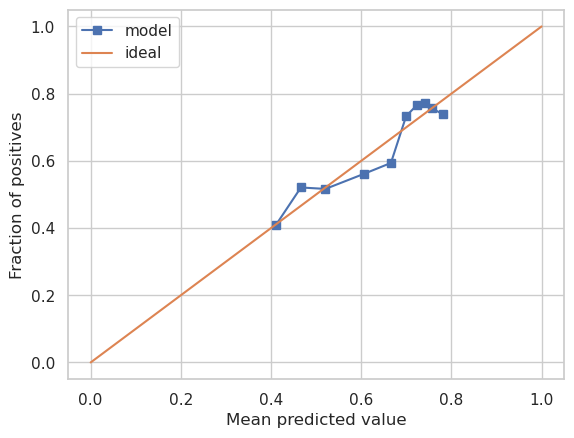

<Figure size 800x270 with 0 Axes>

<Figure size 640x480 with 0 Axes>

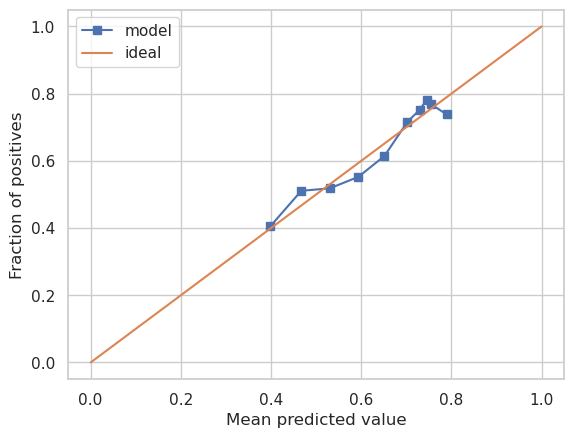

<Figure size 800x270 with 0 Axes>

<Figure size 640x480 with 0 Axes>

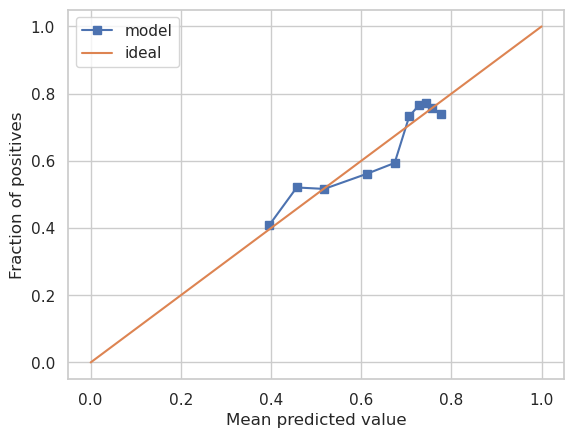

<Figure size 800x270 with 0 Axes>

<Figure size 640x480 with 0 Axes>

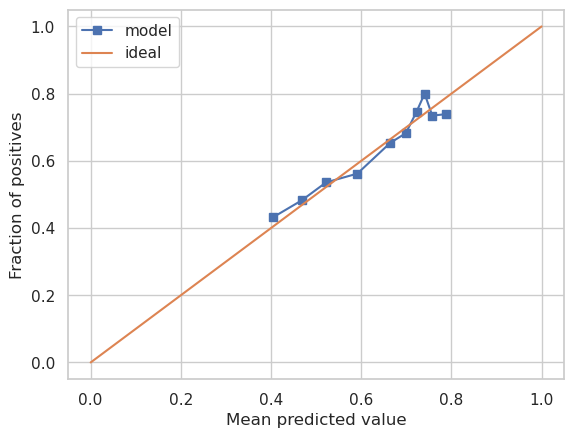

<Figure size 800x270 with 0 Axes>

<Figure size 640x480 with 0 Axes>

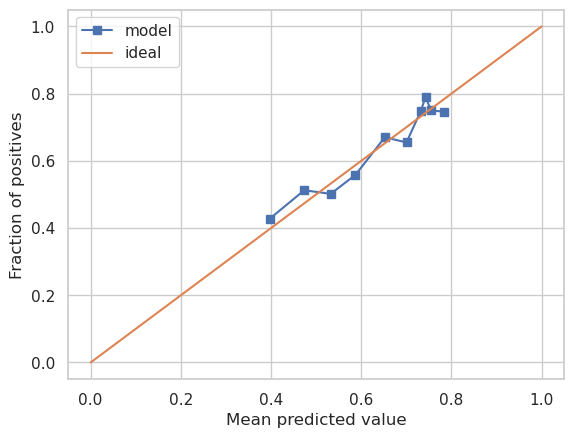

<Figure size 800x270 with 0 Axes>

<Figure size 640x480 with 0 Axes>

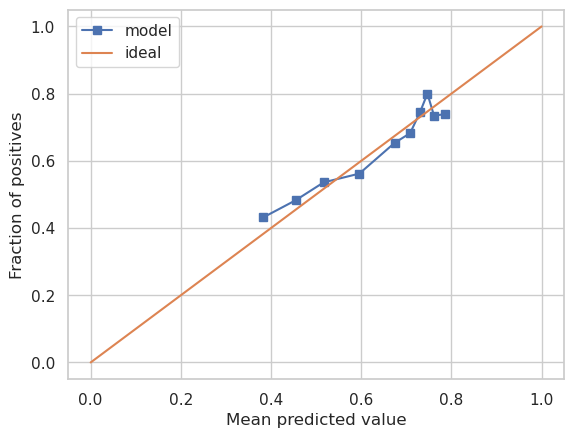

<Figure size 800x270 with 0 Axes>

<Figure size 640x480 with 0 Axes>

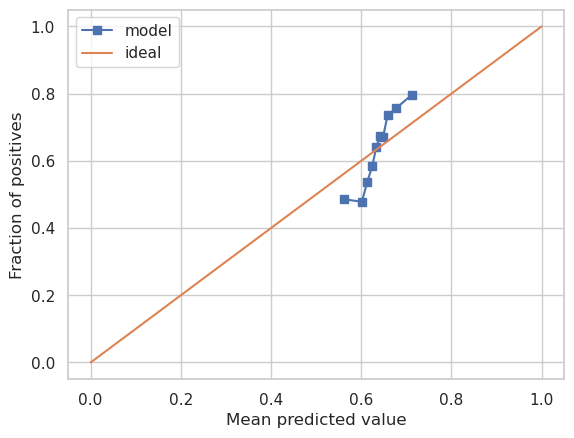

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

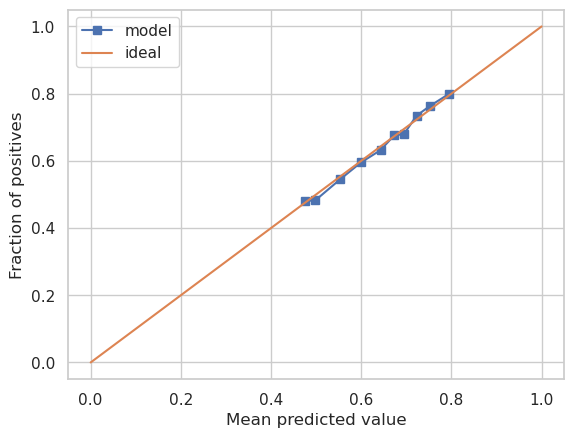

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

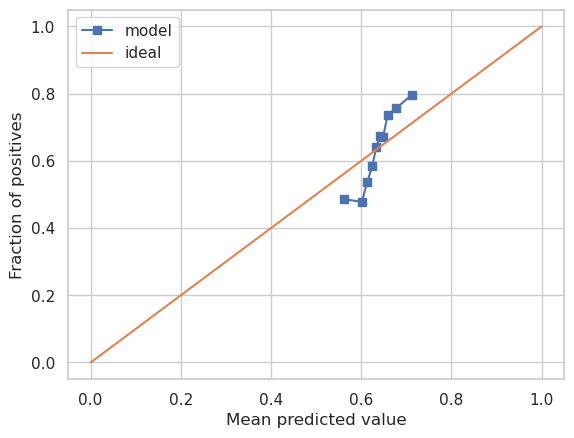

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

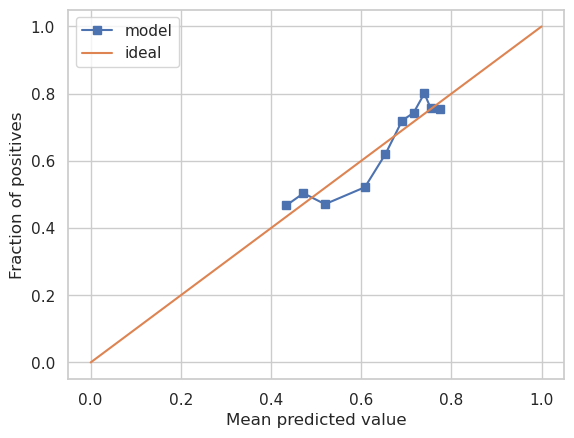

<Figure size 800x270 with 0 Axes>

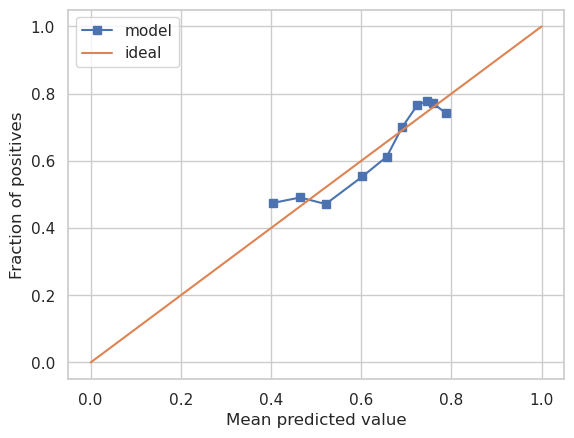

<Figure size 800x270 with 0 Axes>

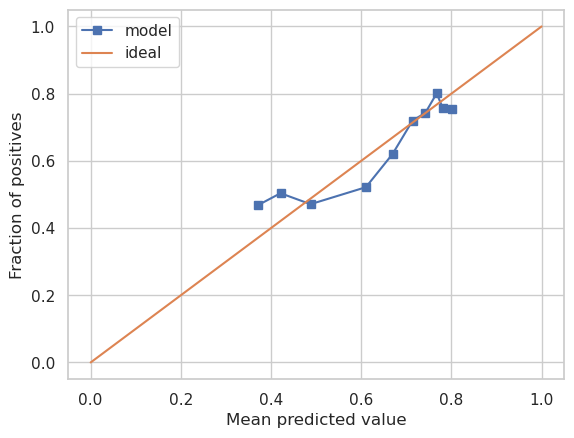

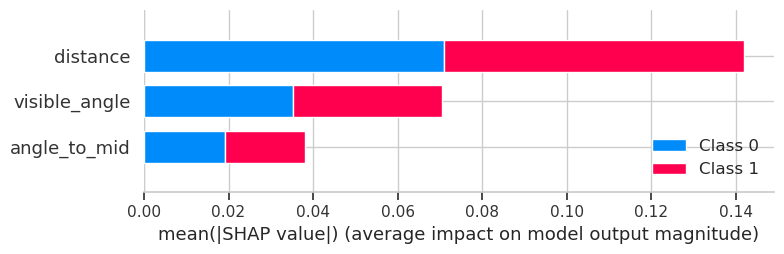

In [8]:
classifiers = create_classifier_dict()
numerical_shot_attributes = dataset_dict.get("num_attr")
categorical_features = dataset_dict.get("cat_attr")

for classifier_name, classifier_obj in classifiers.items():
    ## pipeline for standardization, hyperparameteropt, rfe and os inlc. Training report
    cv_res, best_clf , pipe, result_df, eval_result_df = full_pipeline(comb='T', 
                                                                    X_train=X_train, 
                                                                    y_train=y_train,
                                                                    X_test=X_test,
                                                                    y_test=y_test,
                                                                    numeric_features=numerical_shot_attributes,
                                                                    categorical_features=categorical_features,
                                                                    clf=classifier_obj[0],
                                                                    hyperparameter_dist=classifier_obj[1],
                                                                    result_df=result_df,
                                                                    eval_result_df=eval_result_df,
                                                                    scoring="neg_log_loss",
                                                                    n_iter=20,
                                                                    rfe=False,
                                                                    os=False,
                                                                    log=True,
                                                                    save=True,
                                                                    n_features_to_select=None,
                                                                    calibration=True)
    ##Calculate xG Values
    dataset[classifier_name +"_xG"] = best_clf.predict_proba(X)[:,1]
    detailed_shots_clean[classifier_name +"_xG_baseline"] =  best_clf.predict_proba(detailed_shots_clean)[:,1]
dataset.to_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/simple_shots_dataset_result.csv')

# Detailed Dataset

In [9]:
## loads the dataset
dataset_dict = datasets[1] ##detailed Dataset
dataset = dataset_dict.get("dataset")

## split dataset in feature and target
X = dataset.loc[:, dataset.columns != 'success']
y = dataset['success']

## split dataset in test, validation and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

Optimizing hyperparameters for LGBMClassifier model...
Best hyperparameters {'classifier__learning_rate': 0.03410764224793944, 'classifier__max_depth': 2, 'classifier__num_leaves': 66}
Best cross validation score -0.6287707345692661

['distance', 'visible_angle', 'angle_to_mid', 'time_between_shots_s', 'dist_closest_def', 'shooter_goalkeeper_dist', 'shot_goalkeeper_dist', 'shooter_goalkeeper_angle', 'shot_goalkeeper_angle', 'player_speed', 'number_of_passes', 'ball_posession', 'pressur_index', 'players_in_shot_angle_from_shot', 'players_in_shot_angle_from_player', 'powerplay', 'empty_net']
###Validation Results###
training set results: -0.5365688482860651
training set auc results: 0.8251748251748252

###Evaluation Results###
test set log loss results: 0.5372484305627829
test set auc results: 0.8049853372434017
[[12 19]
 [ 6 49]]
              precision    recall  f1-score   support

           0       0.67      0.39      0.49        31
           1       0.72      0.89      0.80       

#### Calibration curve before Calibration

AUROC: 0.8049853372434017

Gini: 0.6099706744868034

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6492661050459385

ECE (equal width bins):       0.10526424282085109

test set log loss results: 0.5372484305627829

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Calibration curve after isotonic Calibration

AUROC: 0.8090909090909091

Gini: 0.6181818181818182

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6564458099249832

ECE (equal width bins):       0.09405527618442579

test set log loss results: 0.5256482913704862

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Calibration curve after sigmoid Calibration

AUROC: 0.8049853372434017

Gini: 0.6099706744868034

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6578189359866218

ECE (equal width bins):       0.1155830252222681

test set log loss results: 0.5372715059800699

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Optimizing hyperparameters for XGBClassifier model...
Best hyperparameters {'classifier__eta': 0.08786481630691201, 'classifier__max_depth': 1, 'classifier__max_leaves': 6}
Best cross validation score -0.6140520495269429

['distance', 'visible_angle', 'angle_to_mid', 'time_between_shots_s', 'dist_closest_def', 'shooter_goalkeeper_dist', 'shot_goalkeeper_dist', 'shooter_goalkeeper_angle', 'shot_goalkeeper_angle', 'player_speed', 'number_of_passes', 'ball_posession', 'pressur_index', 'players_in_shot_angle_from_shot', 'players_in_shot_angle_from_player', 'powerplay', 'empty_net']
###Validation Results###
training set results: -0.5333275490171842
training set auc results: 0.8601398601398602

###Evaluation Results###
test set log loss results: 0.5379500034037302
test set auc results: 0.7944281524926686
[[12 19]
 [ 7 48]]
              precision    recall  f1-score   support

           0       0.63      0.39      0.48        31
           1       0.72      0.87      0.79        55

    acc

#### Calibration curve before Calibration

AUROC: 0.7944281524926686

Gini: 0.5888563049853373

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6522063612937927

ECE (equal width bins):       0.11731579310672229

test set log loss results: 0.5379500034037302

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after isotonic Calibration

AUROC: 0.7912023460410558

Gini: 0.5824046920821115

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6687483961542331

ECE (equal width bins):       0.08996027012810462

test set log loss results: 0.5309579473916404

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after sigmoid Calibration

AUROC: 0.7944281524926686

Gini: 0.5888563049853373

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.656939187195412

ECE (equal width bins):       0.08876740568599037

test set log loss results: 0.5276142304448623

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

Optimizing hyperparameters for LogisticRegression model...
Best hyperparameters {'classifier__C': 1901.5864276129157}
Best cross validation score -0.636700086239124

['distance', 'visible_angle', 'angle_to_mid', 'time_between_shots_s', 'dist_closest_def', 'shooter_goalkeeper_dist', 'shot_goalkeeper_dist', 'shooter_goalkeeper_angle', 'shot_goalkeeper_angle', 'player_speed', 'number_of_passes', 'ball_posession', 'pressur_index', 'players_in_shot_angle_from_shot', 'players_in_shot_angle_from_player', 'powerplay', 'empty_net']
###Validation Results###
training set results: -0.545711779664465
training set auc results: 0.8006993006993006

###Evaluation Results###
test set log loss results: 0.5744107599285586
test set auc results: 0.7454545454545454
[[17 14]
 [13 42]]
              precision    recall  f1-score   support

           0       0.57      0.55      0.56        31
           1       0.75      0.76      0.76        55

    accuracy                           0.69        86
   macro a

#### Calibration curve before Calibration

AUROC: 0.7454545454545454

Gini: 0.49090909090909074

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6320091628304582

ECE (equal width bins):       0.07558369261791326

test set log loss results: 0.5744107599285586

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after isotonic Calibration

AUROC: 0.7521994134897361

Gini: 0.5043988269794721

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6278021203249297

ECE (equal width bins):       0.07967131875781498

test set log loss results: 0.5722492439609312

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after sigmoid Calibration

AUROC: 0.7454545454545454

Gini: 0.49090909090909074

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6321925882988428

ECE (equal width bins):       0.07363806919834472

test set log loss results: 0.5732237769916163

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

Optimizing hyperparameters for RandomForestClassifier model...



10 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sc.uni-leipzig.de/az091jwou/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sc.uni-leipzig.de/az091jwou/.local/lib/python3.9/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/sc.uni-leipzig.de/az091jwou/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/sc.uni-leipzig.de/az091jwou/.local/lib/pyth

Best hyperparameters {'classifier__n_estimators': 181, 'classifier__max_leaf_nodes': 8, 'classifier__max_depth': 2}
Best cross validation score -0.6166945770893472

['distance', 'visible_angle', 'angle_to_mid', 'time_between_shots_s', 'dist_closest_def', 'shooter_goalkeeper_dist', 'shot_goalkeeper_dist', 'shooter_goalkeeper_angle', 'shot_goalkeeper_angle', 'player_speed', 'number_of_passes', 'ball_posession', 'pressur_index', 'players_in_shot_angle_from_shot', 'players_in_shot_angle_from_player', 'powerplay', 'empty_net']
###Validation Results###
training set results: -0.5619837459083219
training set auc results: 0.7902097902097902

###Evaluation Results###
test set log loss results: 0.5550748775218741
test set auc results: 0.7741935483870968
[[15 16]
 [ 7 48]]
              precision    recall  f1-score   support

           0       0.68      0.48      0.57        31
           1       0.75      0.87      0.81        55

    accuracy                           0.73        86
   macro a

#### Calibration curve before Calibration

AUROC: 0.7741935483870968

Gini: 0.5483870967741935

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6403651884380261

ECE (equal width bins):       0.10960875809804296

test set log loss results: 0.5550748775218742

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


#### Calibration curve after isotonic Calibration

AUROC: 0.7821114369501466

Gini: 0.5642228739002932

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6435285867702312

ECE (equal width bins):       0.07331490145739189

test set log loss results: 0.5368927988817329

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

#### Calibration curve after sigmoid Calibration

AUROC: 0.7741935483870968

Gini: 0.5483870967741935

Fraction of positive cases in the test set: 0.6395348837209303

Mean predicted value in the test set:       0.6434437967857044

ECE (equal width bins):       0.06541538610190491

test set log loss results: 0.5288334425902728

#### Histogram of the probability distribution

#### KDE plots of the probability distribution by class

#### Calibration curve (equal width bins)

#### Calibration curve (equal size bins)

<Figure size 640x480 with 0 Axes>

<Figure size 800x830 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x830 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x830 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x830 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x830 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x830 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

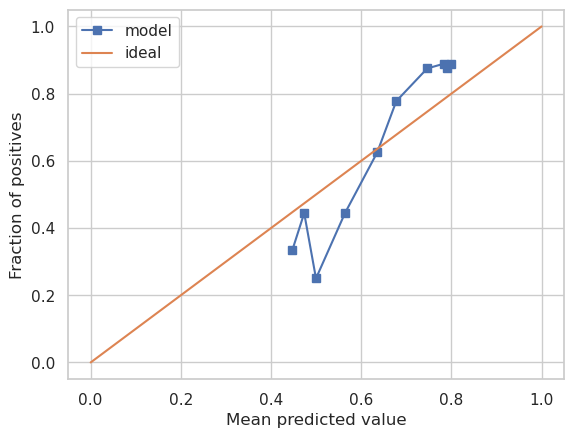

<Figure size 800x830 with 0 Axes>

<Figure size 800x830 with 0 Axes>

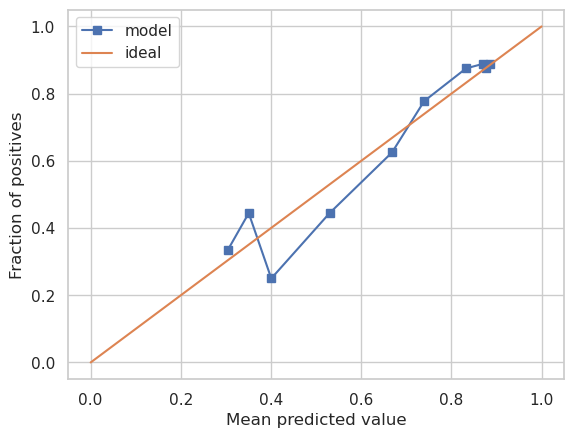

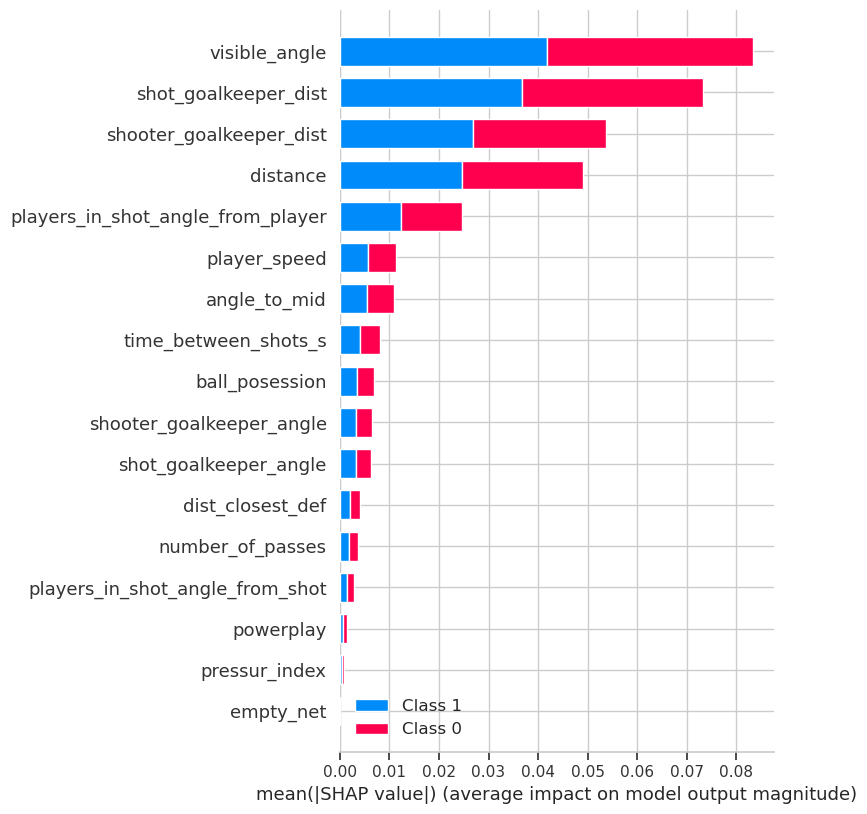

In [10]:
classifiers = create_classifier_dict()
numerical_shot_attributes = dataset_dict.get("num_attr")
categorical_features = dataset_dict.get("cat_attr")

for classifier_name, classifier_obj in classifiers.items():
    ## pipeline for standardization, hyperparameteropt, rfe and os inlc. Training report
    cv_res, best_clf , pipe, result_df, eval_result_df = full_pipeline(comb='T', 
                                                                    X_train=X_train, 
                                                                    y_train=y_train,
                                                                    X_test=X_test,
                                                                    y_test=y_test,
                                                                    numeric_features=numerical_shot_attributes,
                                                                    categorical_features=categorical_features,
                                                                    clf=classifier_obj[0],
                                                                    hyperparameter_dist=classifier_obj[1],
                                                                    result_df=result_df,
                                                                    eval_result_df=eval_result_df,
                                                                    scoring="neg_log_loss",
                                                                    n_iter=20,
                                                                    rfe=False,
                                                                    os=False,
                                                                    log=False,
                                                                    save=False,
                                                                    n_features_to_select=None,
                                                                    calibration=True)
    ##Calculate xG Values
    dataset[classifier_name +"_xG"] = best_clf.predict_proba(X)[:,1]
dataset.to_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/detailed_shots_dataset_result.csv')

# Evaluation

In [ ]:
result_df.to_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Models/new_train_results_cv.csv')
eval_result_df.to_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Models/new_eval_results_cv.csv')

## Training Results

In [19]:
result_df.groupby(['Dataset','Comb', 'Classifier',]).mean()

log_loss_training  auc_train
Dataset Comb Classifier                                 
simple  T    lightgbm               -0.607510   0.685189
             logistic_reg           -0.642812   0.665506
             random_forest          -0.607497   0.690506
             xgboost                -0.606837   0.683352

## Test Results

In [20]:
eval_test = eval_result_df.groupby(['Dataset','Comb', 'Classifier']).mean()
display(eval_test[['log_loss_test', 'auc']])

log_loss_test       auc
Dataset Comb Classifier                            
simple  T    lightgbm            0.623432  0.648702
             logistic_reg        0.650531  0.625442
             random_forest       0.622994  0.650652
             xgboost             0.621559  0.653014